<a href="https://colab.research.google.com/github/akhilesh00k1/cisco-packet-tracer/blob/main/xceptionlr0_1bs16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications import Xception,VGG16,ResNet50
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
data_pd = pd.read_csv('/content/drive/MyDrive/HAM10000/HAM10000_metadata.csv')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
!pwd

/content


In [4]:
os.chdir('/content/drive/MyDrive/HAM10000')

In [5]:
!pwd

/content/drive/MyDrive/HAM10000


In [6]:
train_dir = os.path.join('HAM10000', 'train_dir')
test_dir = os.path.join('HAM10000', 'test_dir')

In [7]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1


In [8]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [9]:
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no' 
    else:
        return 'duplicates'

In [10]:
data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates


In [11]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

In [12]:
train, test_df = train_test_split(df_count, test_size=0.20, stratify=df_count['dx'])


In [13]:
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

#creating train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,train


In [14]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
2679,HAM_0001640,ISIC_0031026,bcc,histo,65.0,male,back,no
3354,HAM_0004248,ISIC_0028812,nv,follow_up,45.0,female,foot,no
5798,HAM_0004906,ISIC_0028522,nv,follow_up,35.0,male,lower extremity,no
1338,HAM_0001328,ISIC_0028442,mel,histo,75.0,male,unknown,no
5128,HAM_0004045,ISIC_0030939,nv,follow_up,45.0,female,trunk,no


In [15]:
# Image id of train and test images
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

In [16]:
len(test_list)

1103

In [17]:
len(train_list)

8912

In [18]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

In [19]:
os.makedirs(train_dir)
os.makedirs(test_dir)

In [20]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [21]:
for i in targetnames:
  directory1=train_dir+'/'+i
  directory2=test_dir+'/'+i
  os.mkdir(directory1)
  os.mkdir(directory2)

In [22]:
for image in train_list:
    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join('/content/drive/MyDrive/HAM10000/', file_name)

    # copying the image from the source to target file
    target = os.path.join(train_dir, label, file_name)

    shutil.copyfile(source, target)

In [23]:
for image in test_list:

    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image 
    source = os.path.join('/content/drive/MyDrive/HAM10000/', file_name)

    # copying the image from the source to target file
    target = os.path.join(test_dir, label, file_name)

    shutil.copyfile(source, target)

In [24]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Augmenting images and storing them in temporary directories 
for img_class in targetnames:

    #creating temporary directories
    # creating a base directory
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # creating a subdirectory inside the base directory for images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_list = os.listdir('HAM10000/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir 
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join('HAM10000/train_dir/' + img_class, file_name)

        # creating a target directory to send images 
        target = os.path.join(img_dir, file_name)

        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = aug_dir

    # Augmented images will be saved to training directory
    save_path = 'HAM10000/train_dir/' + img_class

    # Creating Image Data Generator to augment images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'

    )

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(source_path,save_to_dir=save_path,save_format='jpg',target_size=(224, 224),batch_size=batch_size)

    # Generate the augmented images
    aug_images =  8000

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory 
    shutil.rmtree('aug_dir')

Found 297 images belonging to 1 classes.
Found 479 images belonging to 1 classes.
Found 1011 images belonging to 1 classes.
Found 107 images belonging to 1 classes.
Found 1067 images belonging to 1 classes.
Found 5822 images belonging to 1 classes.
Found 129 images belonging to 1 classes.


In [74]:
train_path = 'HAM10000/train_dir'
test_path = 'HAM10000/test_dir'
batch_size=16

In [75]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)


In [76]:
image_size = 100
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 52012 images belonging to 7 classes.

Test Batches: 
Found 1103 images belonging to 7 classes.


In [77]:
 # Defining base model using Xception module from Keras
training_shape = (100,100,3)
base_model = Xception(include_top=False,weights='imagenet',input_shape = training_shape)
for layer in base_model.layers:
    layer.trainable = True                         # Training all layers from scratch

In [78]:
#Adding layers at end
n_classes = 7
model = base_model.output
model = Flatten()(model)
model = Dense(128)(model)
model = Dropout(0.5)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
output = Dense(n_classes, activation='softmax')(model)
model = Model(inputs=base_model.input, outputs=output)

In [79]:
from tensorflow.keras.optimizers import *


In [80]:
# Compiling the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [81]:
# Model Summary
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 49, 49, 32)   864         ['input_6[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 49, 49, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                            

In [82]:
from tensorflow.keras.callbacks import *

In [83]:
checkpoint=  ModelCheckpoint(filepath = 'Model.hdf5',monitor='val_accuracy',save_best_only=True,save_weights_only=True)


In [84]:
# Defining callback Methods
n_epoch = 300

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [85]:
# Fitting the model
history = model.fit(train_batches,
                    steps_per_epoch=(len(train_df)/10),
      
                    epochs=n_epoch,
                    callbacks=[reduce_lr,early_stop],
                    validation_data=test_batches,validation_steps=len(test_df)/batch_size
                   )

Epoch 1/300
891/891 [==============================] - 73s 76ms/step - loss: 1.2809 - accuracy: 0.5332 - val_loss: 0.4916 - val_accuracy: 0.8386 - lr: 0.0010
Epoch 2/300
891/891 [==============================] - 63s 70ms/step - loss: 0.9393 - accuracy: 0.6673 - val_loss: 0.5126 - val_accuracy: 0.8513 - lr: 0.0010
Epoch 3/300
891/891 [==============================] - 63s 71ms/step - loss: 0.8027 - accuracy: 0.7110 - val_loss: 0.4028 - val_accuracy: 0.8613 - lr: 0.0010
Epoch 4/300
891/891 [==============================] - 63s 71ms/step - loss: 0.7150 - accuracy: 0.7449 - val_loss: 0.4015 - val_accuracy: 0.8694 - lr: 0.0010
Epoch 5/300
891/891 [==============================] - 64s 72ms/step - loss: 0.6420 - accuracy: 0.7721 - val_loss: 0.3423 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 6/300
891/891 [==============================] - 63s 71ms/step - loss: 0.5861 - accuracy: 0.7924 - val_loss: 0.4455 - val_accuracy: 0.8577 - lr: 0.0010
Epoch 7/300
891/891 [==============================]

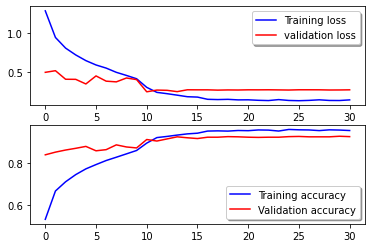

In [86]:
# Plotting the results on Graph
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [39]:
from tensorflow.keras import models
model.load_weights("modelrep.hdf5")

OSError: ignored

In [89]:
predictions = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)


In [90]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report 
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.67      0.73      0.70        30
         bcc       0.66      0.71      0.68        35
         bkl       0.73      0.69      0.71        88
          df       0.62      0.62      0.62         8
         mel       0.74      0.50      0.60        46
          nv       0.96      0.97      0.96       883
        vasc       0.86      0.92      0.89        13

    accuracy                           0.91      1103
   macro avg       0.75      0.74      0.74      1103
weighted avg       0.91      0.91      0.91      1103



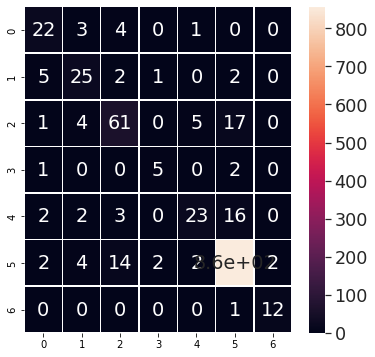

In [91]:
import seaborn as sns
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [88]:
model.save("my_model")

Text(0, 0.5, 'Fraction of incorrect predictions')

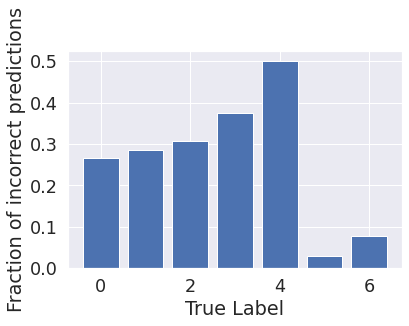

In [92]:

#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

In [93]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='weighted')))


Precision: 0.9090774835012341
Recall: 0.9111514052583862
Accuracy: 0.9111514052583862
weighted Roc score: 0.9813622137412086


In [94]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_test,y_prob,multi_class='ovr',average='macro')))


Precision: 0.7474817314506305
Recall: 0.7370618164664435
Accuracy: 0.9111514052583862
Macro Roc score: 0.9851088550898777


In [95]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.9111514052583862
Recall: 0.9111514052583862
Accuracy: 0.9111514052583862
Micro Roc score: 0.9949559253082407


In [96]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))


The ROC AUC score of akiec is: 0.9904007455731593
The ROC AUC score of bcc is: 0.9884430176565008
The ROC AUC score of bkl is: 0.9763546798029556
The ROC AUC score of df is: 0.9963470319634703
The ROC AUC score of mel is: 0.9628768870058821
The ROC AUC score of nv is: 0.981833625038608
The ROC AUC score of vasc is: 0.9995059985885674


In [97]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

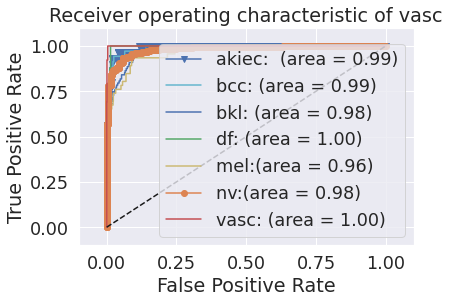

In [98]:
plt.plot(fpr[0], tpr[0],'v-',label='akiec:  (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'c',label='bcc: (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'b',label='bkl: (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'g',label='df: (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'y',label='mel:(area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'o-',label='nv:(area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'r',label='vasc: (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of %s'%targetnames[i])
plt.legend(loc="lower right")
plt.show()

getting predictions on X 

In [46]:
# Reading the data
path = '/content/drive/MyDrive/HAM10000'
images_path = {os.path.splitext(os.path.basename(x))[0]:x
               for x in glob(os.path.join(path,'*','*.jpg'))}

In [47]:
# Encoding target values
lesion_type_dict = {
    'nv':'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
    
}

In [48]:
# Reading Metadata csv file
skin_df = pd.read_csv('/content/drive/MyDrive/HAM10000/HAM10000_metadata.csv')

In [49]:
# Adding extra columns and appending the required created columns in final dataframe
skin_df['path'] = skin_df['image_id'].map(images_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [50]:
# Checking the dataframe info.
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           0 non-null      object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


In [51]:
from tqdm import tqdm

In [52]:
# Image Reading and Resizing.
IMAGE_SIZE=224
def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)




  return img
train_img = []
for img_name in tqdm(skin_df['path'].values):
  train_img.append(read_img(img_name))

100%|██████████| 10015/10015 [00:00<00:00, 10571.47it/s]


In [53]:
from google.colab.patches import cv2_imshow

AttributeError: ignored

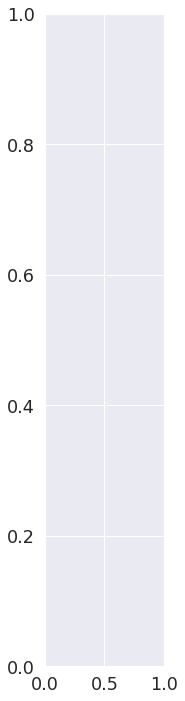

In [54]:
#Visulaizing the images
plt.figure(figsize=(15,12))
for i in range(1,7,1):
    plt.subplot(1,6,i)
    cv2_imshow(train_img[i])
    plt.axis('off')
plt.show()

In [58]:
# Converting it into float arrays and normalizing it
X = np.array(train_img,np.float32)/255
print(X.shape)


(10015,)


TypeError: ignored

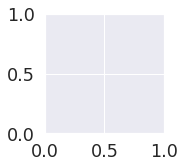

In [59]:
#Visulaizing the normalized images
plt.figure(figsize=(15,12))
for i in range(1,7,1):
    plt.subplot(1,6,i)
    plt.imshow(X[i])
    plt.axis('off')
plt.show()

In [60]:
# Creating Target
y = np.array(skin_df['cell_type_idx'])

In [61]:
# Splitting the data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=28,stratify=y)
x_train,x_val,y_train,y_val =   train_test_split(x_train,y_train,test_size=0.20,random_state=28,stratify=y_train)

In [62]:
# One-Hot Encoding values
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 7)
y_val = to_categorical(y_val , num_classes=7)

In [63]:
#Extaracting Features from last 4 layers of the model
model2 = Model(model.input,model.layers[-4].output)
predictions = model2.predict(X)
predictions[0]

ValueError: ignored

In [64]:
print(len(predictions[0]))

7


In [65]:
X[0]

nan

In [66]:
# Concatenating the predictions with final dataframe
data_df  = skin_df
complete_data = pd.concat([data_df, pd.DataFrame(predictions)], axis=1)
complete_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,0,1,2,3,4,5,6
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2,1.059078e-06,2.223884e-08,0.000009,1.959314e-07,0.745086,0.254904,8.144798e-08
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2,7.587976e-07,1.453072e-08,0.000007,1.380408e-07,0.728766,0.271226,5.946611e-08
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2,2.775718e-03,8.111391e-04,0.010921,1.119680e-03,0.784349,0.199607,4.162648e-04
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2,5.534281e-07,7.001172e-09,0.000003,5.949680e-08,0.837921,0.162075,1.553968e-08
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,None,Benign keratosis-like lesions,2,1.717820e-06,8.125113e-08,0.000014,3.410644e-07,0.864975,0.135009,1.000420e-07


In [ ]:
# Concatenating the predicti

In [67]:
model_json = model2.to_json()
with open("model_v2.json", "w") as json_file:
    json_file.write(model_json)
    
completemodel_json = model.to_json()
with open("completemodel1.json", "w") as json_file:
    json_file.write(completemodel_json)

In [68]:
#Saving Weights to disk.
model2.save_weights("model_v2_weights.h5")
print("Saved model to disk")

model.save_weights("completeweights.h5")
print("Saved model to disk")

Saved model to disk
Saved model to disk


In [69]:
complete_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,0,1,2,3,4,5,6
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2,1.059078e-06,2.223884e-08,0.000009,1.959314e-07,0.745086,0.254904,8.144798e-08
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2,7.587976e-07,1.453072e-08,0.000007,1.380408e-07,0.728766,0.271226,5.946611e-08
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2,2.775718e-03,8.111391e-04,0.010921,1.119680e-03,0.784349,0.199607,4.162648e-04
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2,5.534281e-07,7.001172e-09,0.000003,5.949680e-08,0.837921,0.162075,1.553968e-08
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,None,Benign keratosis-like lesions,2,1.717820e-06,8.125113e-08,0.000014,3.410644e-07,0.864975,0.135009,1.000420e-07


In [70]:
complete_data.columns

Index([    'lesion_id',      'image_id',            'dx',       'dx_type',
                 'age',           'sex',  'localization',          'path',
           'cell_type', 'cell_type_idx',               0,               1,
                     2,               3,               4,               5,
                     6],
      dtype='object')

In [71]:
#One-hot encoding categorical variables in dataframe
dxtype_df = pd.get_dummies(complete_data['dx_type'],drop_first=False)
complete_data = pd.concat([dxtype_df,complete_data],axis=1)
complete_data.head()

,confocal,consensus,follow_up,histo,lesion_id,image_id,dx,dx_type,age,sex,...,path,cell_type,cell_type_idx,0,1,2,3,4,5,6
0,0,0,0,1,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,...,None,Benign keratosis-like lesions,2,1.059078e-06,2.223884e-08,0.000009,1.959314e-07,0.745086,0.254904,8.144798e-08
1,0,0,0,1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,...,None,Benign keratosis-like lesions,2,7.587976e-07,1.453072e-08,0.000007,1.380408e-07,0.728766,0.271226,5.946611e-08
2,0,0,0,1,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,...,None,Benign keratosis-like lesions,2,2.775718e-03,8.111391e-04,0.010921,1.119680e-03,0.784349,0.199607,4.162648e-04
3,0,0,0,1,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,...,None,Benign keratosis-like lesions,2,5.534281e-07,7.001172e-09,0.000003,5.949680e-08,0.837921,0.162075,1.553968e-08
4,0,0,0,1,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,...,None,Benign keratosis-like lesions,2,1.717820e-06,8.125113e-08,0.000014,3.410644e-07,0.864975,0.135009,1.000420e-07


In [72]:
sex_df = pd.get_dummies(complete_data['sex'],drop_first=False)
sex_df.drop(['unknown'],axis=1,inplace=True)
complete_data = pd.concat([sex_df,complete_data],axis=1)
complete_data.head()

,female,male,confocal,consensus,follow_up,histo,lesion_id,image_id,dx,dx_type,...,path,cell_type,cell_type_idx,0,1,2,3,4,5,6
0,0,1,0,0,0,1,HAM_0000118,ISIC_0027419,bkl,histo,...,None,Benign keratosis-like lesions,2,1.059078e-06,2.223884e-08,0.000009,1.959314e-07,0.745086,0.254904,8.144798e-08
1,0,1,0,0,0,1,HAM_0000118,ISIC_0025030,bkl,histo,...,None,Benign keratosis-like lesions,2,7.587976e-07,1.453072e-08,0.000007,1.380408e-07,0.728766,0.271226,5.946611e-08
2,0,1,0,0,0,1,HAM_0002730,ISIC_0026769,bkl,histo,...,None,Benign keratosis-like lesions,2,2.775718e-03,8.111391e-04,0.010921,1.119680e-03,0.784349,0.199607,4.162648e-04
3,0,1,0,0,0,1,HAM_0002730,ISIC_0025661,bkl,histo,...,None,Benign keratosis-like lesions,2,5.534281e-07,7.001172e-09,0.000003,5.949680e-08,0.837921,0.162075,1.553968e-08
4,0,1,0,0,0,1,HAM_0001466,ISIC_0031633,bkl,histo,...,None,Benign keratosis-like lesions,2,1.717820e-06,8.125113e-08,0.000014,3.410644e-07,0.864975,0.135009,1.000420e-07


In [73]:
# Dropping variables since we have encoded them.
X_labels = complete_data.drop(['lesion_id','image_id','dx_type','dx','path','cell_type','cell_type_idx','sex','path','localization'],axis=1,inplace=False)
y_label = complete_data['cell_type_idx']

In [74]:
X_labels.head()

,female,male,confocal,consensus,follow_up,histo,age,0,1,2,3,4,5,6
0,0,1,0,0,0,1,80.0,1.059078e-06,2.223884e-08,0.000009,1.959314e-07,0.745086,0.254904,8.144798e-08
1,0,1,0,0,0,1,80.0,7.587976e-07,1.453072e-08,0.000007,1.380408e-07,0.728766,0.271226,5.946611e-08
2,0,1,0,0,0,1,80.0,2.775718e-03,8.111391e-04,0.010921,1.119680e-03,0.784349,0.199607,4.162648e-04
3,0,1,0,0,0,1,80.0,5.534281e-07,7.001172e-09,0.000003,5.949680e-08,0.837921,0.162075,1.553968e-08
4,0,1,0,0,0,1,75.0,1.717820e-06,8.125113e-08,0.000014,3.410644e-07,0.864975,0.135009,1.000420e-07


predictions 

In [75]:
# Making predictions from CNN
complete_data.to_csv('skin_cancer_v2.csv')
preds = model.predict(x_test)
preds

ValueError: ignored

In [76]:

lst = []
for a in preds:
    lst.append(np.argmax(a))

NameError: ignored

In [ ]:
lst

In [ ]:
confusion_matrix(lst,y_test)

In [ ]:
accuracy_score(lst,y_test)

In [ ]:
print(classification_report(y_test,lst))

using features extracted to  make predictions 

In [77]:
# Dropping unnamed column values
skin_df = pd.read_csv('skin_cancer_v2.csv')
skin_df.drop(['Unnamed: 0'],axis=1,inplace=True)
skin_df.head()

,female,male,confocal,consensus,follow_up,histo,lesion_id,image_id,dx,dx_type,...,path,cell_type,cell_type_idx,0,1,2,3,4,5,6
0,0,1,0,0,0,1,HAM_0000118,ISIC_0027419,bkl,histo,...,NaN,Benign keratosis-like lesions,2,1.059078e-06,2.223884e-08,0.000009,1.959314e-07,0.745086,0.254904,8.144798e-08
1,0,1,0,0,0,1,HAM_0000118,ISIC_0025030,bkl,histo,...,NaN,Benign keratosis-like lesions,2,7.587976e-07,1.453072e-08,0.000007,1.380408e-07,0.728766,0.271226,5.946611e-08
2,0,1,0,0,0,1,HAM_0002730,ISIC_0026769,bkl,histo,...,NaN,Benign keratosis-like lesions,2,2.775718e-03,8.111391e-04,0.010921,1.119681e-03,0.784349,0.199607,4.162647e-04
3,0,1,0,0,0,1,HAM_0002730,ISIC_0025661,bkl,histo,...,NaN,Benign keratosis-like lesions,2,5.534281e-07,7.001172e-09,0.000003,5.949680e-08,0.837921,0.162075,1.553968e-08
4,0,1,0,0,0,1,HAM_0001466,ISIC_0031633,bkl,histo,...,NaN,Benign keratosis-like lesions,2,1.717820e-06,8.125113e-08,0.000014,3.410644e-07,0.864975,0.135009,1.000420e-07


In [78]:
skin_df.head()

,female,male,confocal,consensus,follow_up,histo,lesion_id,image_id,dx,dx_type,...,path,cell_type,cell_type_idx,0,1,2,3,4,5,6
0,0,1,0,0,0,1,HAM_0000118,ISIC_0027419,bkl,histo,...,NaN,Benign keratosis-like lesions,2,1.059078e-06,2.223884e-08,0.000009,1.959314e-07,0.745086,0.254904,8.144798e-08
1,0,1,0,0,0,1,HAM_0000118,ISIC_0025030,bkl,histo,...,NaN,Benign keratosis-like lesions,2,7.587976e-07,1.453072e-08,0.000007,1.380408e-07,0.728766,0.271226,5.946611e-08
2,0,1,0,0,0,1,HAM_0002730,ISIC_0026769,bkl,histo,...,NaN,Benign keratosis-like lesions,2,2.775718e-03,8.111391e-04,0.010921,1.119681e-03,0.784349,0.199607,4.162647e-04
3,0,1,0,0,0,1,HAM_0002730,ISIC_0025661,bkl,histo,...,NaN,Benign keratosis-like lesions,2,5.534281e-07,7.001172e-09,0.000003,5.949680e-08,0.837921,0.162075,1.553968e-08
4,0,1,0,0,0,1,HAM_0001466,ISIC_0031633,bkl,histo,...,NaN,Benign keratosis-like lesions,2,1.717820e-06,8.125113e-08,0.000014,3.410644e-07,0.864975,0.135009,1.000420e-07


In [79]:
X_labels = skin_df.drop(['lesion_id','image_id','dx','dx_type','sex','localization','path','cell_type','cell_type_idx','age'],axis=1,inplace=False)
y_label = skin_df['cell_type_idx']

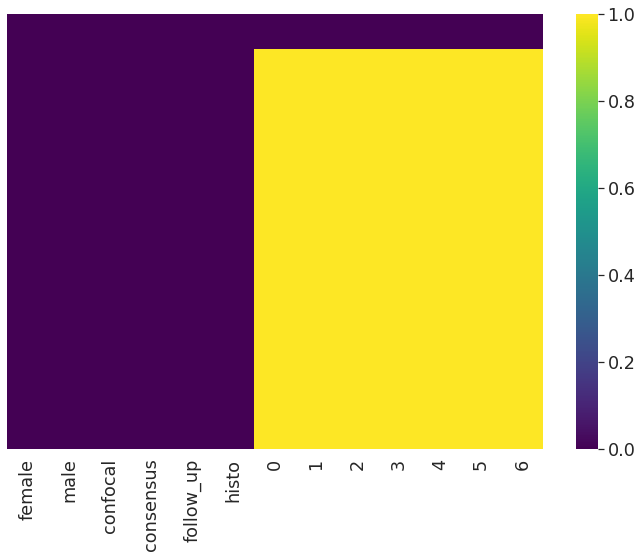

In [80]:

# Checking Null values
plt.figure(figsize=(12,8))
sns.heatmap(X_labels.isnull(),cmap='viridis',yticklabels=False)

In [81]:
# Splitting the dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_labels,y_label,test_size=0.10,random_state=28,stratify=y_label)

random forest classifier

In [82]:
from sklearn.ensemble import RandomForestClassifier
rfc  = RandomForestClassifier(random_state=28)
rfc.fit(X_train,y_train)

ValueError: ignored

In [ ]:
y_pred = rfc.predict(X_test)

In [ ]:
confusion_matrix(y_test,y_pred)

In [ ]:
print(classification_report(y_test,y_pred))

XGboost

In [ ]:
# XGBOOST
import xgboost as xgb
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=-1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=1855, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=0)